# World Wide Products Inc.

## Introduction

The dataset used in this project contains observations from a variety of products. The products are labeled by a number code only. Each observation also consists of each product's associated warehouse, category code, and date ordered.  The purpose of this project is to use time series models to model and predict the target variable (Product demand, measured by the variable Order_Demand). I will prepare the data for prediction and then perform several models on two products -- Product 0979 and Product 0704 --  which I chose based on their visual distribution and differing number of observations.

In [247]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
%matplotlib inline

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

from pmdarima import auto_arima 

import warnings
warnings.filterwarnings("ignore")

The following function definiton is used to execute the Dickey-Fuller test which is used to determine series stationarity. Stationarity will be discussed in more detail when this method is called.

In [248]:
def perform_adf_test(series):
    result=adfuller(series)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' %result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {}'.format(key, value))

## Data

Here, I read in the data. As discussed in the intro, the target variable we will be predicting is Order_Demand. As seen in the table below, there are 1,048,575 observations. The data is composed if many different products. Later I will create separate datasets for individual products.

In [249]:
df=pd.read_csv("/Users/anissakhan/Dropbox/Nissa_stuff/KU_CS/EECS731/731-Project-5-Khan/Data/RawData/HistoricalProductDemand.csv")
df

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
0,Product_0993,Whse_J,Category_028,2012/7/27,100
1,Product_0979,Whse_J,Category_028,2012/1/19,500
2,Product_0979,Whse_J,Category_028,2012/2/3,500
3,Product_0979,Whse_J,Category_028,2012/2/9,500
4,Product_0979,Whse_J,Category_028,2012/3/2,500
...,...,...,...,...,...
1048570,Product_1791,Whse_J,Category_006,2016/4/27,1000
1048571,Product_1974,Whse_J,Category_006,2016/4/27,1
1048572,Product_1787,Whse_J,Category_006,2016/4/28,2500
1048573,Product_0901,Whse_J,Category_023,2016/10/7,50


### Data Cleaning

First I convert the variable types to more useable forms. All object that are strings will be converted to strings in case they are needed for string comparison purposes. The target variable, Order_Demand will first be converted to a string and later to a number. I have to convert it to a string first because there are negative values in the Order_Demand data that are represented with parentheses (i.e. -24 is represented as (24)). Therefore (#) can't be directly converted to a number.

In [250]:
df.dtypes

Product_Code        object
Warehouse           object
Product_Category    object
Date                object
Order_Demand        object
dtype: object

In [251]:
df['Warehouse'] = df['Warehouse'].astype('string')
df['Date'] = df['Date'].astype('string')
df['Product_Category'] = df['Product_Category'].astype('string')
df['Product_Code'] = df['Product_Code'].astype('string')
df.dtypes

Product_Code        string
Warehouse           string
Product_Category    string
Date                string
Order_Demand        object
dtype: object

As discussed earlier, Order_Demand is first converted to a string and then I call str.strip() just in case there are extra spaces around the string. 

In [252]:
df['Order_Demand'] = df['Order_Demand'].astype('string')

In [253]:
df.Order_Demand = df.Order_Demand.str.strip()

Before moving forward with the Order_Demand conversion I first have to eliminate any null values so the for loop will run appropriately. It can be seen in the table below that there are null values in the Date variable.

In [254]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 5 columns):
 #   Column            Non-Null Count    Dtype 
---  ------            --------------    ----- 
 0   Product_Code      1048575 non-null  string
 1   Warehouse         1048575 non-null  string
 2   Product_Category  1048575 non-null  string
 3   Date              1037336 non-null  string
 4   Order_Demand      1048575 non-null  string
dtypes: string(5)
memory usage: 40.0 MB


All missing values from Date are removed. Now it can be seen below that there are 1,037,336 non-null observations. The indices is then reset so the for loops will run correctly. Resetting the index creates a new column variable called 'Index' so I drop this variable in the same step it is created.

In [255]:
df.dropna(subset = ["Date"], inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1037336 entries, 0 to 1048574
Data columns (total 5 columns):
 #   Column            Non-Null Count    Dtype 
---  ------            --------------    ----- 
 0   Product_Code      1037336 non-null  string
 1   Warehouse         1037336 non-null  string
 2   Product_Category  1037336 non-null  string
 3   Date              1037336 non-null  string
 4   Order_Demand      1037336 non-null  string
dtypes: string(5)
memory usage: 47.5 MB


In [256]:
df=df.reset_index()
df.drop(columns =["index"], inplace = True)
df.head()

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
0,Product_0993,Whse_J,Category_028,2012/7/27,100
1,Product_0979,Whse_J,Category_028,2012/1/19,500
2,Product_0979,Whse_J,Category_028,2012/2/3,500
3,Product_0979,Whse_J,Category_028,2012/2/9,500
4,Product_0979,Whse_J,Category_028,2012/3/2,500


Now, to enable Order_Demand type conversion to a number, I strip the parentheses from the value and replace them with a '-' to indicate a negative number. I print out 2 of the negative observations for demonstration purposes. There were a total of 5899 negative values in the dataset. This equates to 0.5% of the overall observations.

In [257]:
count=0
for i in range(0,len(df['Order_Demand'])):
    if("(" in df['Order_Demand'][i]):
        df['Order_Demand'][i] = df['Order_Demand'][i].rstrip(")")
        df['Order_Demand'][i] = df['Order_Demand'][i].lstrip("(")
        df['Order_Demand'][i] = "-" + df['Order_Demand'][i]
        count=count+1
        #df.drop([i], inplace=True, axis=0)
        if(count<3):
            print(df.iloc[i])
            
print('Times Order_Demand variable is negative =', count)

Product_Code        Product_2169
Warehouse                 Whse_A
Product_Category    Category_024
Date                    2012/8/9
Order_Demand                  -1
Name: 112289, dtype: string
Product_Code        Product_2132
Warehouse                 Whse_A
Product_Category    Category_009
Date                   2012/11/1
Order_Demand                 -24
Name: 112306, dtype: string
Times Order_Demand variable is negative = 5899


Now that the negative variables are represented with '-' instead of parentheses I can finally convert Order_Demand to a numerical datatype. I choose float in case there are any data entry anomalies that result in non-whole product measurements.

In [258]:
df['Order_Demand'] = df['Order_Demand'].astype('float')

Since the documentation for the Order_Demand variable consists of a single line that says "single order qty", I am unable to determine whether or not the negative Order_Demand values are miscoded or intentional. Since there are only 0.5% negative observations in the entire dataset, I drop them from the data by multiplying them by -1 to make them positive observations. This approach assumes the negative observations are miscoded and intended to be positive. Since there few negative observations I conclude this approach will not definitively affect the predictions.

In [259]:
count=0
for i in range(0,len(df['Order_Demand'])):
    if(df['Order_Demand'][i] < 0):
        #print(df.iloc[i])
        #df.drop([i],inplace=True, axis=0)
        df['Order_Demand'][i] = (df['Order_Demand'][i])*(-1)
        count=count+1
        
            
print('Times Order_Demand variable is negative =', count)

Times Order_Demand variable is negative = 5899


We can see now that Order_Demand is of type float, which is what we wanted.

In [260]:
df.dtypes

Product_Code         string
Warehouse            string
Product_Category     string
Date                 string
Order_Demand        float64
dtype: object

Before we create the separate product datasets, we need to convert our indices. Since we want to apply time series models to our data we need use the Date variable as our index. Below I convert Date to a DatetimeIndex data type. I assume the format of the dates is year/month/day since I observe the first observation to have date 2012/07/27 and there are not 27 months. 

In [261]:
df.Date = pd.to_datetime(df.Date)
df.set_index('Date', inplace=True)

In [262]:
df['Year'] = df.index.year
df['Month'] = df.index.month
df['WeekdayName'] = df.index.dayofweek
df.head()

,Product_Code,Warehouse,Product_Category,Order_Demand,Year,Month,WeekdayName
Date,,,,,,,
2012-07-27,Product_0993,Whse_J,Category_028,100.0,2012,7,4
2012-01-19,Product_0979,Whse_J,Category_028,500.0,2012,1,3
2012-02-03,Product_0979,Whse_J,Category_028,500.0,2012,2,4
2012-02-09,Product_0979,Whse_J,Category_028,500.0,2012,2,3
2012-03-02,Product_0979,Whse_J,Category_028,500.0,2012,3,4


### Datasets for individual products

I now choose 2 products based on each one's visual distribution. The products are 0704 and 0979. I plot each one below. dfProd is the 0704 dataset and dfProd2 is the 0979 dataset.

First I create the dataset for product 0704.

In [263]:
dfProd=df.query("Product_Code == 'Product_0704'")[['Product_Code', 'Warehouse', 'Product_Category', 'Order_Demand']]
dfProd.head()

,Product_Code,Warehouse,Product_Category,Order_Demand
Date,,,,
2012-03-02,Product_0704,Whse_J,Category_001,1.0
2012-01-17,Product_0704,Whse_J,Category_001,10.0
2012-02-14,Product_0704,Whse_J,Category_001,10.0
2012-03-07,Product_0704,Whse_J,Category_001,10.0
2012-05-15,Product_0704,Whse_J,Category_001,10.0


Product 0704 has only 345 observations ranging from 2012 to 2016.

In [264]:
dfProd.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 345 entries, 2012-03-02 to 2016-06-27
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Product_Code      345 non-null    string 
 1   Warehouse         345 non-null    string 
 2   Product_Category  345 non-null    string 
 3   Order_Demand      345 non-null    float64
dtypes: float64(1), string(3)
memory usage: 13.5 KB


In [265]:
dfProd.describe()

,Order_Demand
count,345.000000
mean,5.550725
std,5.053022
min,1.000000
25%,2.000000
50%,5.000000
75%,5.000000
max,30.000000


Below is the graphed distribution of Product 0704. Since there are fewer observations you can easily see the shape of the distribution. The quantity demanded/ordered ranges from 1 to 30 items. This item must either be large and expensive such as construction equipment or be something that doesn't require large quantity orders.

Text(0, 0.5, 'Demand')

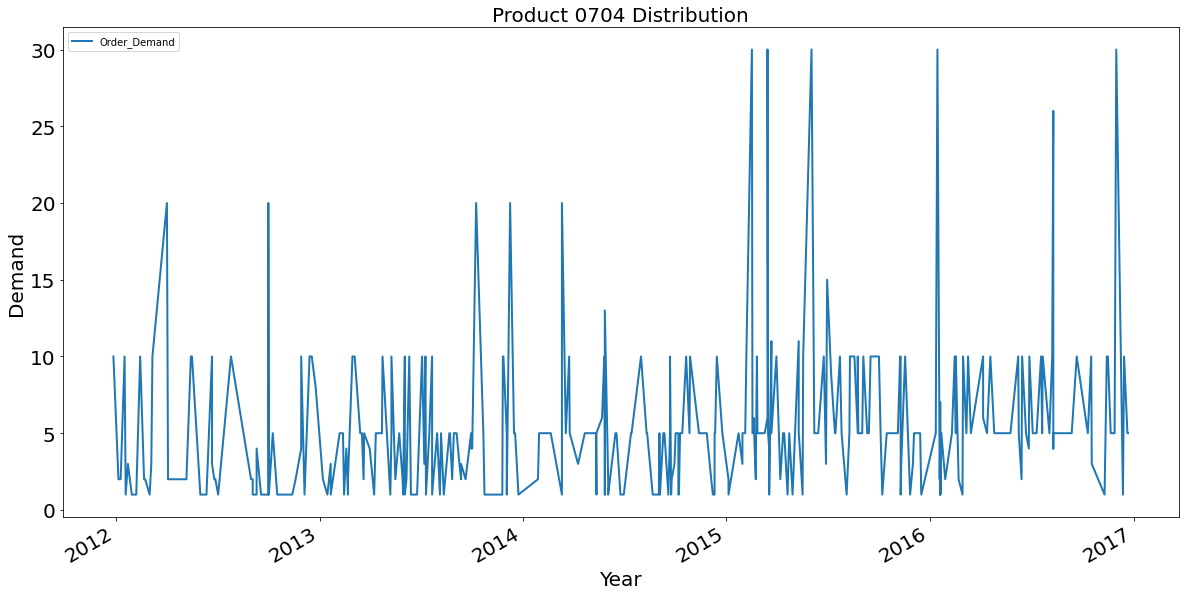

In [266]:
dfProd.plot(figsize=(20,10), linewidth=2, fontsize=20)
plt.xlabel('Year', fontsize=20);
plt.title('Product 0704 Distribution', fontsize=20)
plt.ylabel('Demand', fontsize=20)

Next I create the dataset for product 0979.

In [267]:
dfProd2=df.query("Product_Code == 'Product_0979'")[['Product_Code', 'Warehouse', 'Product_Category', 'Order_Demand']]
dfProd2.head()

,Product_Code,Warehouse,Product_Category,Order_Demand
Date,,,,
2012-01-19,Product_0979,Whse_J,Category_028,500.0
2012-02-03,Product_0979,Whse_J,Category_028,500.0
2012-02-09,Product_0979,Whse_J,Category_028,500.0
2012-03-02,Product_0979,Whse_J,Category_028,500.0
2012-04-19,Product_0979,Whse_J,Category_028,500.0


Compared to the previous dataset this one has many more observations (over 3000). The data also ranges from 2012 to 2016.

In [268]:
dfProd2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3889 entries, 2012-01-19 to 2016-12-13
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Product_Code      3889 non-null   string 
 1   Warehouse         3889 non-null   string 
 2   Product_Category  3889 non-null   string 
 3   Order_Demand      3889 non-null   float64
dtypes: float64(1), string(3)
memory usage: 151.9 KB


In [269]:
dfProd2.describe()

,Order_Demand
count,3889.000000
mean,1885.446130
std,4405.222077
min,0.000000
25%,200.000000
50%,500.000000
75%,1200.000000
max,97100.000000


Below is the graphed distribution of Product 0979. Since there are more observations it is harder to see the distribution, but easier to see the general shape of the observations. There are a few datapoints that stick out above the rest. While these could be outliers, they could also just be very large orders. This product's orders range from 0 to 97,100, but the average order size is 1885. The 0 demand could be coded as such because nothing was ordered in that period of time. This product must be something that is cheap/small and requires large, frequent orders. Some products that come to mind are small office supplies or toiletries.

Text(0, 0.5, 'Demand')

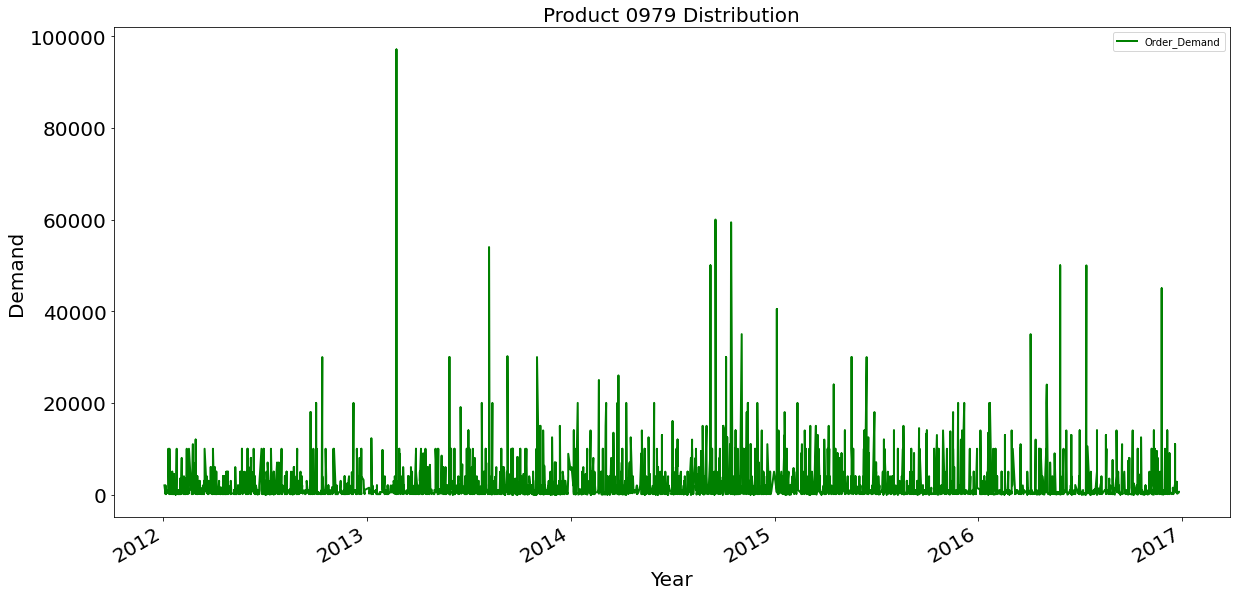

In [270]:
dfProd2.plot(figsize=(20,10), linewidth=2, fontsize=20, color='green')
plt.xlabel('Year', fontsize=20);
plt.title('Product 0979 Distribution', fontsize=20)
plt.ylabel('Demand', fontsize=20)

## Time Series Analysis

### Check for Stationarity

I now create a few new datasets that contain just the Order_Demand variable. Recall the date is also included, but doesn't need to be explicitly included because it is the index of the dataset. These datasets are used for checking stationarity so I will call them dfProd_check and dfProd2_check.

In [393]:
dfProd_check=dfProd[['Order_Demand']]
dfProd2_check=dfProd2[['Order_Demand']]

Stationarity is a measure of how stationary the dataset is. This means the mean, variance, and covariance (of ith term and (i+m)th term) are not a function of time. It is important to verify stationarity before applying time series models because it enables the models to have more accurate predictions be removing the effect of time on the series. Even though we are using the variation of the series over time to make our predicions, there could be external events that result in general trends in the data. We want to remove these trends to improve our predictions.

There are several ways to check that the data is stationary. One easy way is to plot the rolling average and rolling standard deviation of the dataset. Below I plot both for the 0704 dataset.

The rolling average appears to have a slight upward trend indicating it might not be completely stationary. On the other hand, the standard deviation graph just below does not have an explicit trend. It could be helpful to have another way to check stationarity. 

Text(0, 0.5, 'Demand')

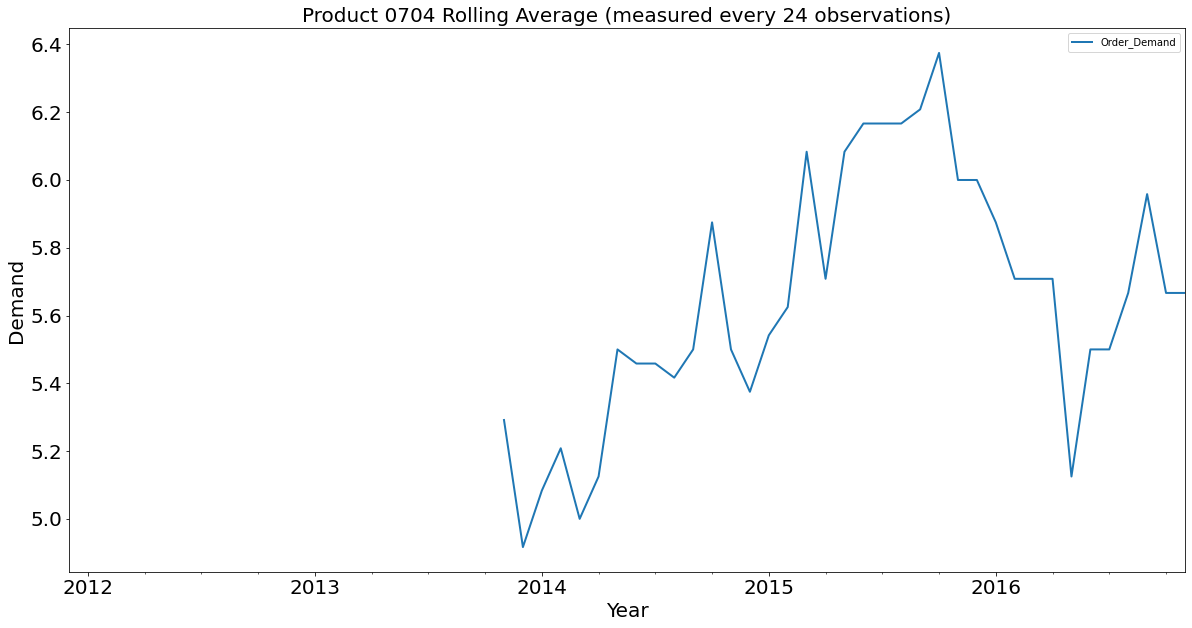

In [394]:
dfProd_check.rolling(24).mean().plot(figsize=(20,10), linewidth=2, fontsize=20)
plt.xlabel('Year', fontsize=20);
plt.title('Product 0704 Rolling Average (measured every 24 observations)', fontsize=20)
plt.ylabel('Demand', fontsize=20)

Text(0, 0.5, 'Demand')

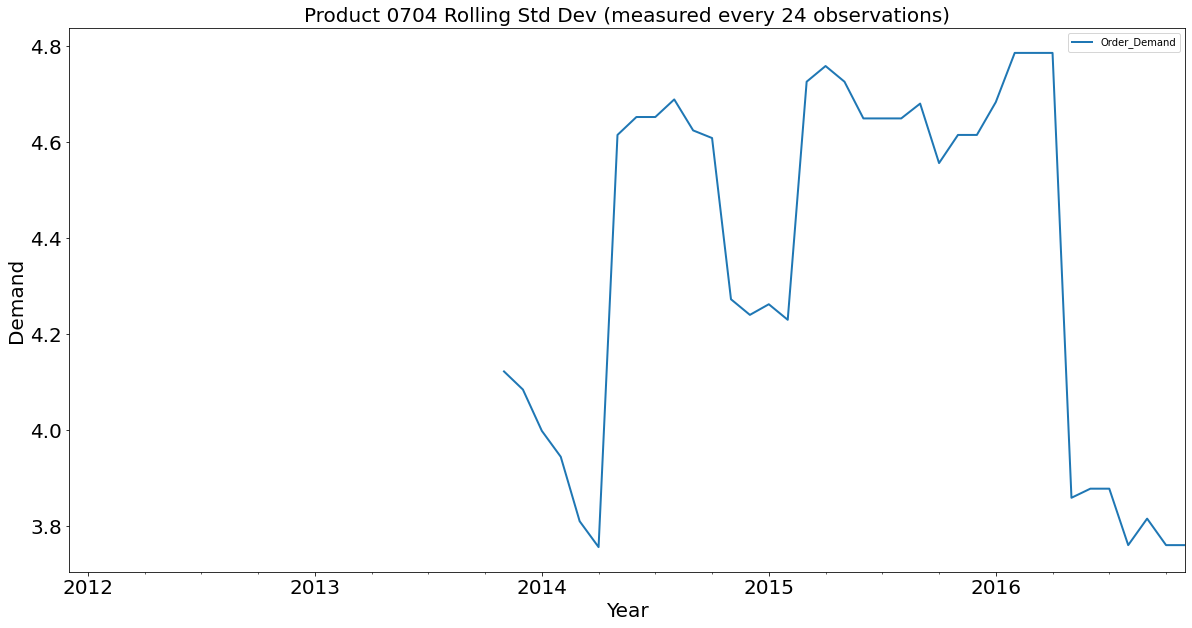

In [395]:
dfProd_check.rolling(24).std().plot(figsize=(20,10), linewidth=2, fontsize=20)
plt.xlabel('Year', fontsize=20);
plt.title('Product 0704 Rolling Std Dev (measured every 24 observations)', fontsize=20)
plt.ylabel('Demand', fontsize=20)

Another way we can check for stationarity is by running the Augmented Dickey-Fuller (ADF) Test. The time series is stationary if the p-value<0.05 and the ADF Statistic is close to the ADF critical values. For dfProd, both of these are true so it is likely that our series of Order_Demand is stationary and we can safely run time series models.

In [396]:
perform_adf_test(dfProd['Order_Demand'])

ADF Statistic: -10.069281
p-value: 0.000000
Critical Values:
	1%: -3.5463945337644063
	5%: -2.911939409384601
	10%: -2.5936515282964665


We will now go through the same process for Product 0979. Neither the rolling average nor the rolling standard deviation plots appear to have any clear trend. It is likely this product's series is stationary.

Text(0, 0.5, 'Demand')

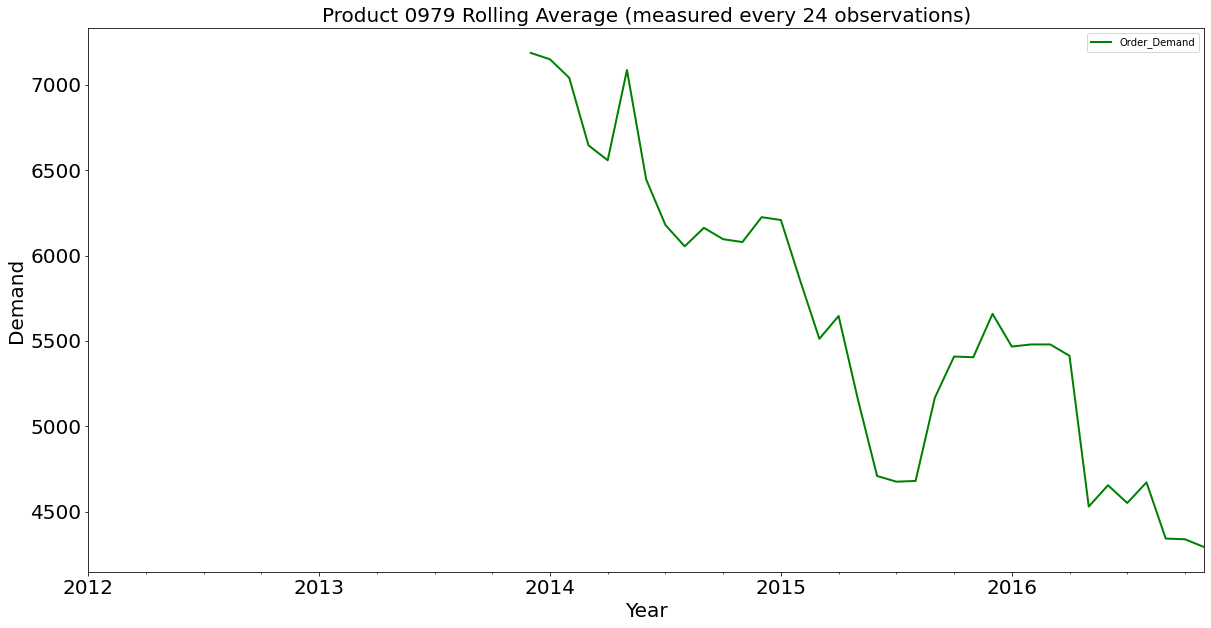

In [397]:
dfProd2_check.rolling(24).mean().plot(figsize=(20,10), linewidth=2, fontsize=20, color='green')
plt.xlabel('Year', fontsize=20);
plt.title('Product 0979 Rolling Average (measured every 24 observations)', fontsize=20)
plt.ylabel('Demand', fontsize=20)

Text(0, 0.5, 'Demand')

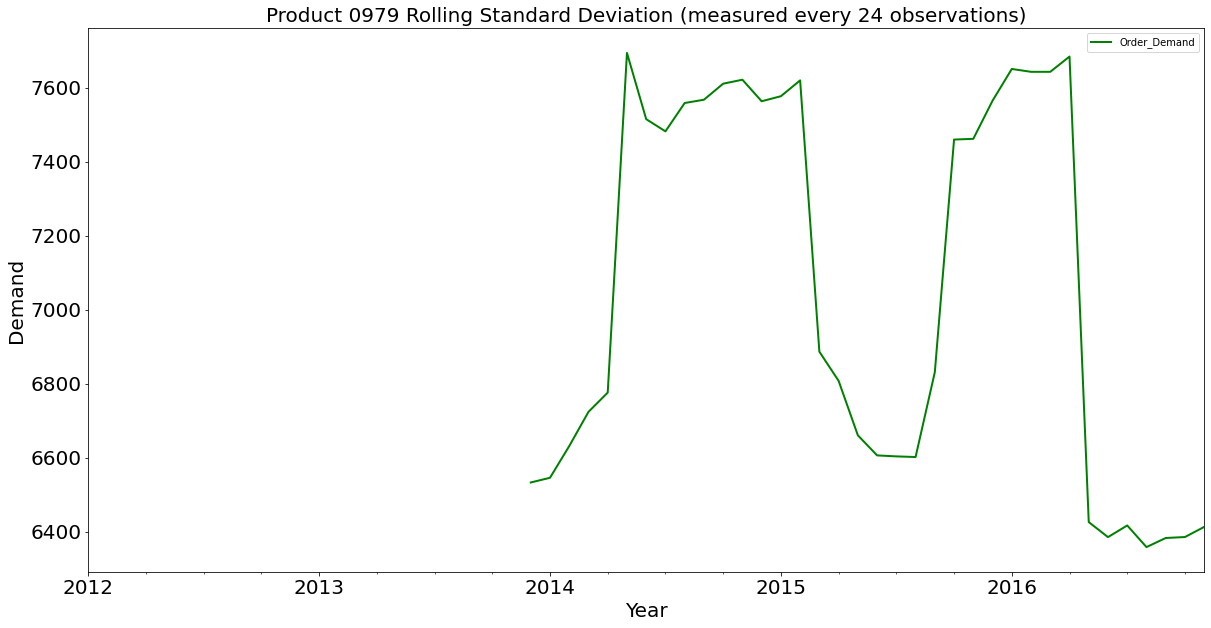

In [398]:
dfProd2_check.rolling(24).std().plot(figsize=(20,10), linewidth=2, fontsize=20, color='green')
plt.xlabel('Year', fontsize=20);
plt.title('Product 0979 Rolling Standard Deviation (measured every 24 observations)', fontsize=20)
plt.ylabel('Demand', fontsize=20)

For product 0979 the p-value<0.05 but the ADF Statistic is further away from the ADF Critical values. It is still likely the series is stationary.

In [399]:
perform_adf_test(dfProd2['Order_Demand'])

ADF Statistic: -7.236250
p-value: 0.000000
Critical Values:
	1%: -3.548493559596539
	5%: -2.912836594776334
	10%: -2.594129155766944


### Adding dataset index frequency

Before running any time series models we also need to verify our indices have a frequency indicated. The frequency of the index indicates how often there is an observation. In our case it is unclear what the data frequency is. The documenation mentions performing monthly forecasting. Therefore I will assign a monthly level of frequency to the DatetimeIndex.

First we verify our index is of type DatetimeIndex. We then see the DatetimeIndex does not currently have a frequency. In order to assign a frequency level we need to verify there are no duplicate indices in the data. When I first tried to run the frequency assignment calls, I got errors indicating there are duplicate indices in the datasets. This could happen if multiple separate entities place orders on the same date. To remedy this, I combine any indices with the same value (date) and add up their Order_Demand fields. 

In [400]:
type(df.index)

pandas.core.indexes.datetimes.DatetimeIndex

In [401]:
print(df.index.freq)

None


This is where I combine observations with the same Date.

In [402]:
dfProd=dfProd.groupby(level=0).sum()
dfProd2=dfProd2.groupby(level=0).sum()

I can now assign the monthly frequency to the data. This compresses the data into monthly observations. I use the forward fill method. If there is no observation on a given month, forward fill will fill Order_Demand with the value from the previously observed value up until the next observed value.

In [403]:
dfProd = dfProd.asfreq('M', method='ffill')
dfProd2 = dfProd2.asfreq('M', method='ffill')

The adjusted series that we will be predicting are plotted below for product 0704 and 0979.

Text(0, 0.5, 'Demand')

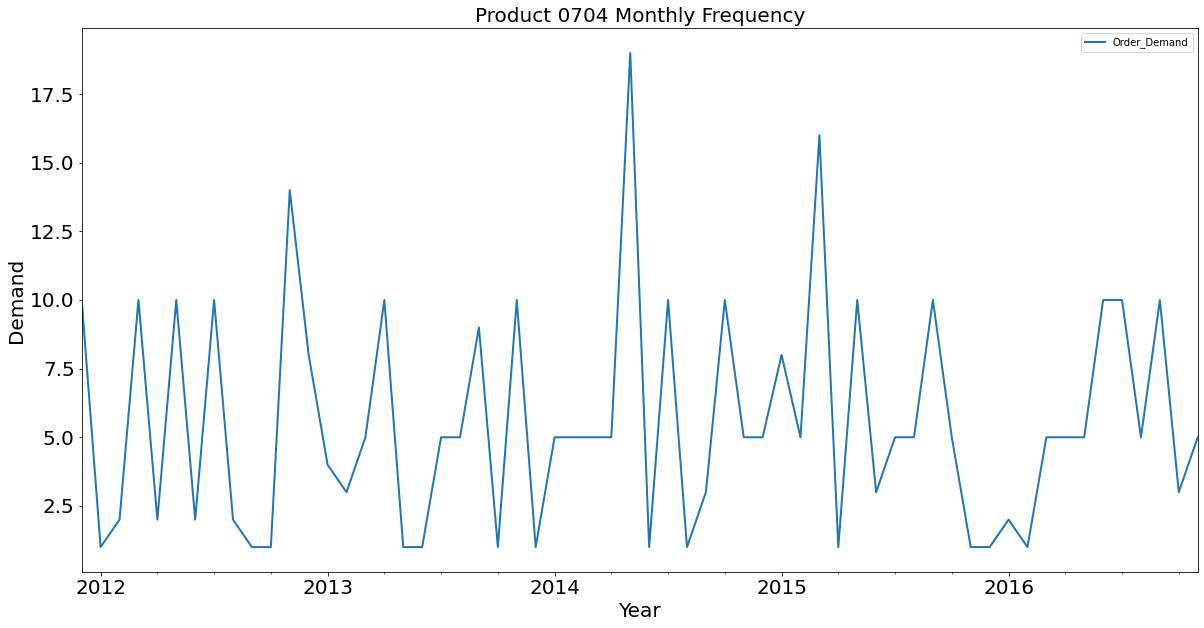

In [404]:
dfProd.plot(figsize=(20,10), linewidth=2, fontsize=20)
plt.xlabel('Year', fontsize=20);
plt.title('Product 0704 Monthly Frequency', fontsize=20)
plt.ylabel('Demand', fontsize=20)

Text(0, 0.5, 'Demand')

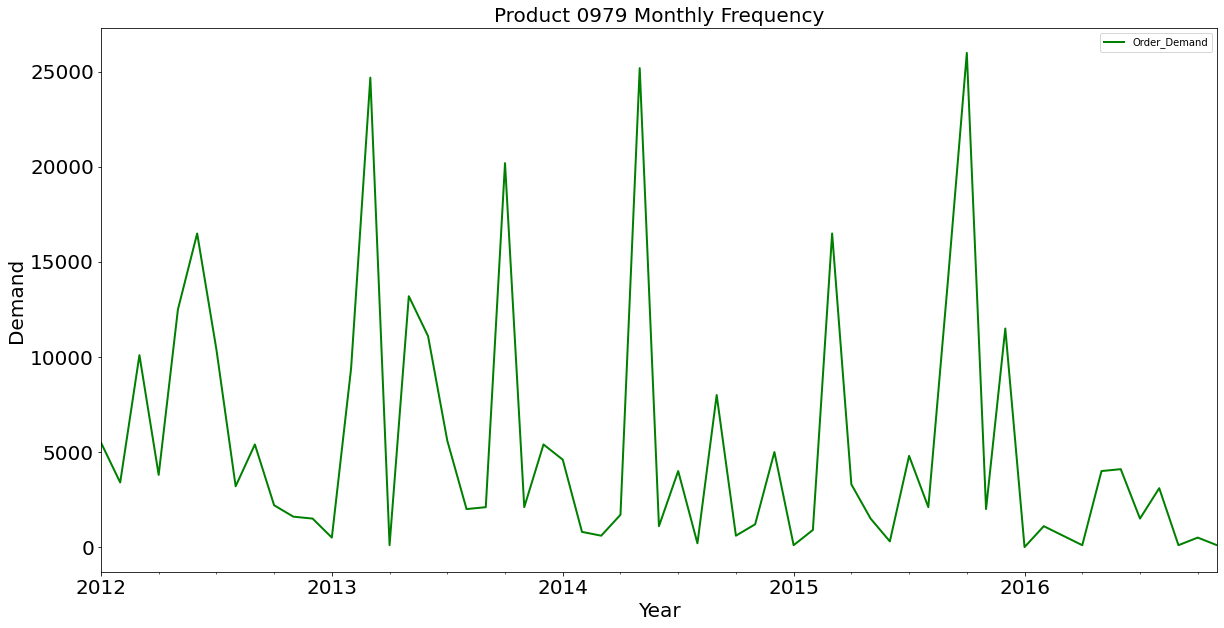

In [405]:
dfProd2.plot(figsize=(20,10), linewidth=2, fontsize=20, color='green')
plt.xlabel('Year', fontsize=20);
plt.title('Product 0979 Monthly Frequency', fontsize=20)
plt.ylabel('Demand', fontsize=20)

### Decomposition

Decomposition allows us to see the target variable's series graphed alongside its general trendline, seasonal component, and residual values. The decomposition for both products are graphed below. For both products, neither appears to have an explicit seasonal component.  Both of these products must be needed in unpredictable, varying quantities throughout the year.

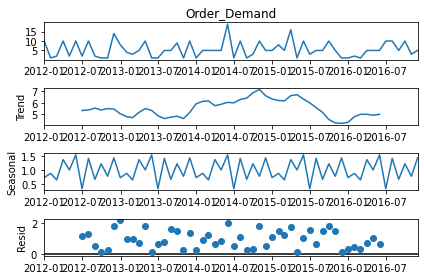

In [406]:
result = seasonal_decompose(dfProd['Order_Demand'], model ='multiplicative') # ETS Decomposition 
   
fig=result.plot() # ETS plot 
fig.show()

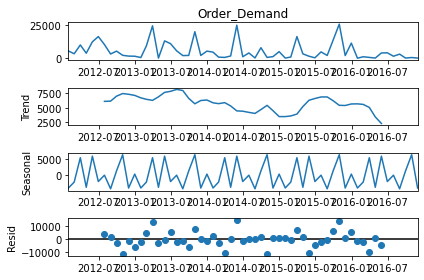

In [407]:
result = seasonal_decompose(dfProd2['Order_Demand'], model ='additive') # ETS Decomposition
 
fig=result.plot() # ETS plot 
fig.show()

### Two Approaches to Modeling

I use 2 approaches to applying ARIMA to the data.

First I follow along with the geeks for geeks tutorial to predict 12 months of data. This tutorial applies an Auto ARIMA function that runs a variety of AR, MA, ARMA, and ARIMA models to determine which model is the best fit for the data.

Later I will use AR, ARMA, and ARIMA in succession (following a tutorial from Medium--article linked in ReadMe) to compare the prediction results for the product data across the entire time period. The data modeling results from this approach end up more accurate than the results from the geeks for geeks approach. However the prediction results from the geeks for geeks approach contain more variation than those from the latter approach.

#### 1) Auto ARIMA Recommendation Approach (Geeks for Geeks Tutorial)

#### a) Product 0704
As discussed above, this tutorial applies an Auto ARIMA function that runs a variety of AR, MA, ARMA, and ARIMA models to determine which model is the best fit for the data. It uses the Akaike Information Critera (AIC) to recommend the best model. The lower the AIC, the better fit that model is for your data. This function recommends SARIMAX for both of my product datasets. This can be seen in the SARIMAX Results output below. SARIMAX stands for Seasonal ARIMA with exogenous variables. It is a version of ARIMA that accounts for the seasonal component of the data.

In [408]:
# Fit auto_arima function to dataset 
stepwise_fit = auto_arima(dfProd['Order_Demand'], start_p = 1, start_q = 1, 
                          max_p = 3, max_q = 3, m = 12, 
                          start_P = 0, seasonal = True, 
                          d = None, D = 1, trace = True, 
                          error_action ='ignore',   # we don't want to know if an order does not work 
                          suppress_warnings = True,  # we don't want convergence warnings 
                          stepwise = True)           # set to stepwise 
  
# To print the summary 
stepwise_fit.summary() 

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.42 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=308.136, Time=0.01 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=297.882, Time=0.07 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=295.563, Time=0.11 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=306.141, Time=0.01 sec
 ARIMA(0,0,1)(0,1,0)[12] intercept   : AIC=308.805, Time=0.03 sec
 ARIMA(0,0,1)(1,1,1)[12] intercept   : AIC=297.427, Time=0.13 sec
 ARIMA(0,0,1)(0,1,2)[12] intercept   : AIC=297.414, Time=0.17 sec
 ARIMA(0,0,1)(1,1,0)[12] intercept   : AIC=297.936, Time=0.06 sec
 ARIMA(0,0,1)(1,1,2)[12] intercept   : AIC=inf, Time=0.67 sec
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,0,2)(0,1,1)[12] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=295.620, Time=0.10 sec
 ARIMA(1,0,2)(0,1,1)[12] intercept   : AIC=inf, Time=0.34 sec
 ARIMA(0,0,1)(0,1,1)[12]             : AIC=293.618, T

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   60
Model:             SARIMAX(0, 0, 1)x(0, 1, 1, 12)   Log Likelihood                -143.809
Date:                            Mon, 12 Oct 2020   AIC                            293.618
Time:                                    14:25:41   BIC                            299.232
Sample:                                         0   HQIC                           295.740
                                             - 60                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.1511      0.173     -0.875      0.382      -0.490       0.187
ma.S.L12      -0.8546      0.708     -1.207      0.227      -2.242       0.533
sigma2        17.8872     11.834      1.511      0.131      -5.308      41.082
===================================================================================
Ljung-Box (Q):                       36.63   Jarque-Bera (JB):                 1.79
Prob(Q):                              0.62   Prob(JB):                         0.41
Heteroskedasticity (H):               1.26   Skew:                             0.47
Prob(H) (two-sided):                  0.65   Kurtosis:                         2.93
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

After determining the model (SARIMAX (0,0,1)(0,1,1,12)), we split the data and then fit the training dataset with the model. The results are then plotted below.

In [409]:
# Split data into train / test sets 
train = dfProd.iloc[:len(dfProd)-12] 
test = dfProd.iloc[len(dfProd)-12:] # set one year(12 months) for testing 
  
# Fit a SARIMAX(0, 1, 1)x(2, 1, 1, 12) on the training set 
from statsmodels.tsa.statespace.sarimax import SARIMAX 
  
model = SARIMAX(train['Order_Demand'],  
                order = (0, 0, 1),  
                seasonal_order =(0, 1, 1, 12)) 
  
result = model.fit() 
#result.summary()

The prediction results for the test portion of the dataset are seen below in the graph. The blue line represents the predictions and the orange line represents the actual series. As you can see, these results from the recommended model are not very accurate. 

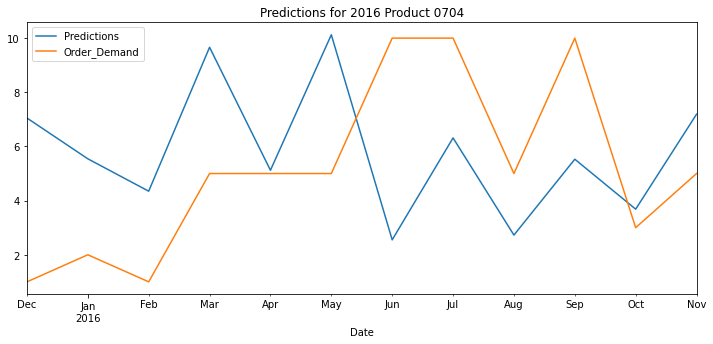

In [420]:
start = len(train) 
end = len(train) + len(test) - 1
  
# Predictions for one-year against the test set 
predictions = result.predict(start, end, 
                             typ = 'levels').rename("Predictions") 
  
# plot predictions and actual values 
predictions.plot(legend = True) 
test['Order_Demand'].plot(figsize = (12, 5), legend = True, title='Predictions for 2016 Product 0704') 

Besides looking visually at our plotted predictions we can use the Mean Squared Error (MSE) to evaluate the accuracy of our model. Below we see the MSE for this model is 17.9. The MSE "is calculated as the average of the squared forecast error values." An MSE closer to zero means the fit of the model is better (less error). Our MSE is not close to zero but it is not too large either, meaning the fit is okay but definitely not great. This is consistent with our visual observations.

In [423]:
# Load specific evaluation tools 
from sklearn.metrics import mean_squared_error 

# Calculate mean squared error 
mean_squared_error(test['Order_Demand'], predictions)

17.32073896241239

We can use our model to now forecast predictions for demand into the future (past the end date of the dataset). In the plot below, the orange line is the forecasted values for the Order_Demand series. The values have less variation than the original series and seem to follow a pattern. The pattern looks similar to the seasonal pattern we saw in the decomposition. 

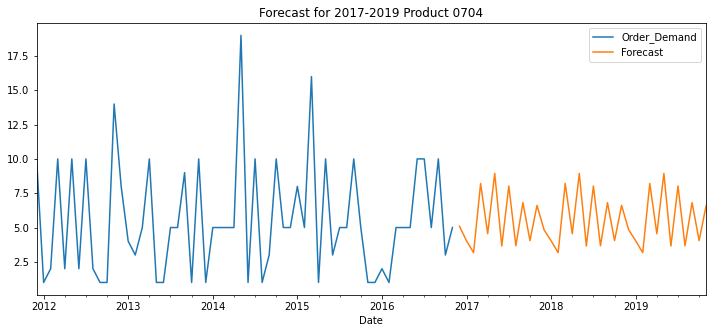

In [419]:
# Train the model on the full dataset 
model = model = SARIMAX(dfProd['Order_Demand'],  
                        order = (0, 0, 1),  
                        seasonal_order =(0, 1, 1, 12)) 
result = model.fit() 
  
# Forecast for the next 3 years 
forecast = result.predict(start = len(dfProd),  
                          end = (len(dfProd)-1) + 3 * 12,  
                          typ = 'levels').rename('Forecast') 
  
# Plot the forecast values 
dfProd['Order_Demand'].plot(figsize = (12, 5), legend = True, title='Forecast for 2017-2019 Product 0704') 
forecast.plot(legend = True) 

#### b) Product 0979

I now repeat the same process for Product 0979 and view the results. In this case, the auto ARIMA test recommends another SARIMAX model with different parameters. The results for this product are worse than those from 0704. Based on the AIC alone, I don't expect good results here. The AIC for product 0704 was in the 200s, while the AIC for this product's model is in the 900s. Recall, a lower AIC indicates a better model fit.

In [425]:
# Fit auto_arima function to dataset 
stepwise_fit = auto_arima(dfProd2['Order_Demand'], start_p = 1, start_q = 1, 
                          max_p = 3, max_q = 3, m = 12, 
                          start_P = 0, seasonal = True, 
                          d = None, D = 1, trace = True, 
                          error_action ='ignore',   # we don't want to know if an order does not work 
                          suppress_warnings = True,  # we don't want convergence warnings 
                          stepwise = True)           # set to stepwise 
  
# To print the summary 
stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.51 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1003.006, Time=0.01 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=987.611, Time=0.06 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=990.301, Time=0.05 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1001.577, Time=0.01 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1004.482, Time=0.01 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=980.837, Time=0.51 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=990.389, Time=0.20 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=976.971, Time=0.26 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=989.312, Time=0.06 sec
 ARIMA(1,0,0)(1,1,2)[12] intercept   : AIC=990.141, Time=0.20 sec
 ARIMA(1,0,0)(0,1,2)[12] intercept   : AIC=inf, Time=0.58 sec
 ARIMA(1,0,0)(2,1,2)[12] intercept   : AIC=981.281, Time=0.87 sec
 ARIMA(0,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=0.28 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                   59
Model:             SARIMAX(1, 0, 0)x(1, 1, [1], 12)   Log Likelihood                -483.485
Date:                              Mon, 12 Oct 2020   AIC                            976.971
Time:                                      14:54:47   BIC                            986.221
Sample:                                           0   HQIC                           980.452
                                               - 59                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    398.5652    618.031      0.645      0.519    -812.754    1609.885
ar.L1          0.1850      0.166      1.116      0.264      -0.140       0.510
ar.S.L12      -0.3274      0.155     -2.114      0.035      -0.631      -0.024
ma.S.L12      -0.8346      0.247     -3.377      0.001      -1.319      -0.350
sigma2      4.531e+07      0.010   4.76e+09      0.000    4.53e+07    4.53e+07
===================================================================================
Ljung-Box (Q):                       32.25   Jarque-Bera (JB):                 5.99
Prob(Q):                              0.80   Prob(JB):                         0.05
Heteroskedasticity (H):               0.94   Skew:                             0.83
Prob(H) (two-sided):                  0.90   Kurtosis:                         3.57
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.16e+26. Standard errors may be unstable.
"""

In [426]:
# Split data into train / test sets 
train = dfProd2.iloc[:len(dfProd2)-12] 
test = dfProd2.iloc[len(dfProd2)-12:] # set one year(12 months) for testing 
  
# Fit a SARIMAX(1, 0, 0)x(1, 1, 1, 12) on the training set 
from statsmodels.tsa.statespace.sarimax import SARIMAX 
  
model = SARIMAX(train['Order_Demand'],  
                order = (1, 0, 0),  
                seasonal_order =(1, 1, [1], 12)) 
  
result = model.fit() 
#result.summary()

As expected, in the plot below the results are a lot less accurate than product 0704's results. The predicted values have many peaks, while the actual Order_Demand in 2016 was fairly low and constant.

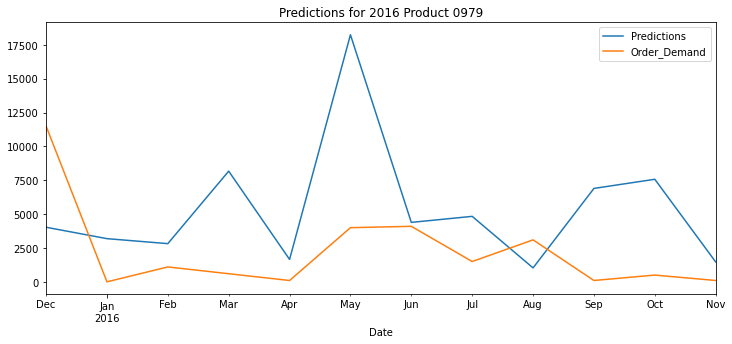

In [427]:
start = len(train) 
end = len(train) + len(test) - 1
  
# Predictions for one-year against the test set 
predictions = result.predict(start, end, 
                             typ = 'levels').rename("Predictions") 
  
# plot predictions and actual values 
predictions.plot(legend = True) 
test['Order_Demand'].plot(figsize = (12, 5), legend = True, title='Predictions for 2016 Product 0979') 

The MSE is a huge number when compared to our previous MSE of 17 for the other product. The fit of this model is not good as indicated both by the plot above and MSE below.

In [387]:
# Calculate mean squared error 
mean_squared_error(test['Order_Demand'], predictions)

14867845.945314879

Regardless, I still want to run the forecast to see how the results look. The forecasted values have less extreme variations but still vary some.

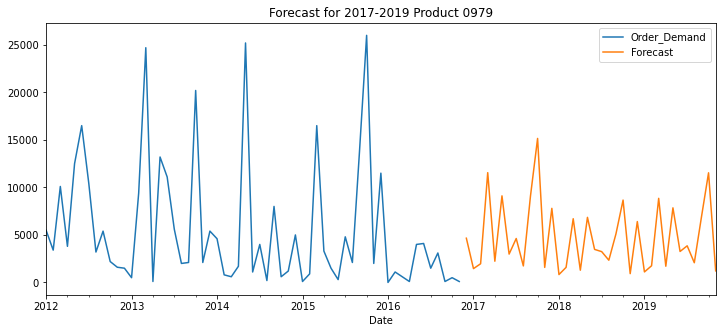

In [428]:
# Train the model on the full dataset 
model = model = SARIMAX(dfProd2['Order_Demand'],  
                        order = (1, 0, 0),  
                        seasonal_order =(1, 1, [1], 12)) 
result = model.fit() 
  
# Forecast for the next 3 years 
forecast = result.predict(start = len(dfProd2),  
                          end = (len(dfProd2)-1) + 3 * 12,  
                          typ = 'levels').rename('Forecast') 
  
# Plot the forecast values 
dfProd2['Order_Demand'].plot(figsize = (12, 5), legend = True, title='Forecast for 2017-2019 Product 0979') 
forecast.plot(legend = True) 

#### 2) AR, ARMA, and ARIMA Succession Approach (Medium tutorial)

#### a) Product 0704

Since the results using SARIMAX were not great, I now want to try simply running AR, ARMA, and ARIMA models to see if we get better results.

First, I run AR(8) on the data. We previously ran the Dickey-Fuller test to check stationarity. The results were positive (data was stationary) so we don't need to do any transformations. AR(8) uses the previous 8 observed values to predict the next value. The results are graphed below. These results look much more accurate than the SARIMAX results found in the previous section.

In [467]:
decomposition = seasonal_decompose(df_log) 
model = ARIMA(df_log, order=(2,1,2))
results = model.fit(disp=-1)
plt.plot(df_log_shift)
plt.plot(results.fittedvalues, color='red')

AttributeError: 'Figure' object has no attribute 'plot'

The MSE of this model is 13.8 which is closer to 0 and therefore more accurate than the SARIMAX results found earlier.

In [442]:
# Calculate mean squared error 
mean_squared_error(dfProd['Order_Demand'], results.fittedvalues)

13.84177605572164

In [466]:
decomposition = seasonal_decompose(dfProd) 
model = ARIMA(dfProd, order=(8,0,2))
results = model.fit(disp=-1)
plt.plot(dfProd)
plt.plot(results.fittedvalues, color='red')

AttributeError: 'Figure' object has no attribute 'plot'

The purpose of ARIMA compared to ARMA is to introduce differencing. "Differencing subtracts the current value from the previous and can be used to transform a time series into one that’s stationary." Therefore, if we are unsure about the stationarity of our model, we can try ARIMA to see if it improves fit. 

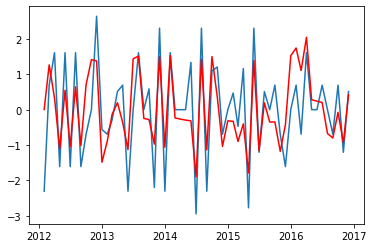

In [389]:
decomposition = seasonal_decompose(df_log) 
model = ARIMA(df_log, order=(2,1,2))
results = model.fit(disp=-1)
plt.plot(df_log_shift)
plt.plot(results.fittedvalues, color='red')

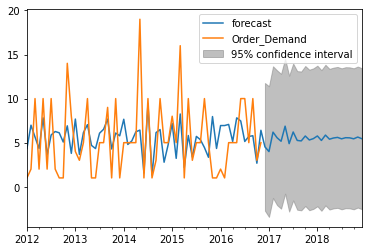

In [465]:
#(4 x12)+ (12 x 3) = 84 We have 4 years of data and want to predict next 3 years
plt=results.plot_predict(1,84)
plt.show()

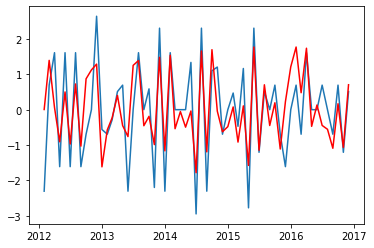

In [341]:
decomposition = seasonal_decompose(df_log) 
model = ARIMA(df_log, order=(1,1,2))
results = model.fit(disp=-1)
plt.plot(df_log_shift)
plt.plot(results.fittedvalues, color='red')

In [342]:
dfprod_shift = dfProd - dfProd.shift()
dfprod_shift.dropna(inplace=True)

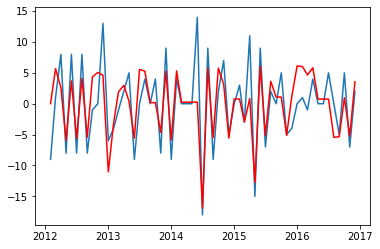

In [343]:
decomposition = seasonal_decompose(dfProd) 
model = ARIMA(dfProd, order=(2,1,2))
results = model.fit(disp=-1)
plt.plot(dfprod_shift)
plt.plot(results.fittedvalues, color='red')

In [344]:
dfprod2_shift = dfProd2 - dfProd2.shift()
dfprod2_shift.dropna(inplace=True)

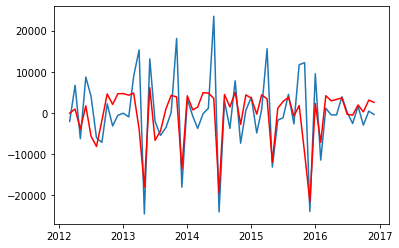

In [345]:
decomposition = seasonal_decompose(dfProd2) 
model = ARIMA(dfProd2, order=(1,1,1)) # (10, 0, 0) is AR(10), (1, 0, 1) is ARMA(1,1)
results = model.fit(disp=-1)
plt.plot(dfprod2_shift)
plt.plot(results.fittedvalues, color='red')